<a href="https://colab.research.google.com/github/shailesh008/imgClassUsingCNN/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing all libraries and dependnecies
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import os
import sys

from random import shuffle
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# setting hyper parameters
# images are of size (80,80,3)
IMG_SIZE = 80

#setting more epochs does not yield better accuracy, so trying with 30 
epochs = 30

step_size = 8
IMG_SIZE_ALEXNET = 227
validating_size = 40
nodes_fc1 = 4096
nodes_fc2 = 4096
output_classes = 4 

In [2]:
# as we had a very huge dataset we were not able to upload it on the google cloud server and run it to get rezised image in numpy array format. So we ran the code to convert images to numpy array in our local machines uploaded the output to GCS and used those values.
#the numpy array format of our images file is named  'train_data.npy' and 'test_data.npy'
#uploading the dataset files to google cloud server test_data_mc.npy and train_data_mc.npy.
#attached code for it on github

from google.colab import files
uploaded = files.upload()

Saving test_data.npy to test_data.npy
Saving train_data.npy to train_data.npy


In [0]:
#loading variables with data values
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')

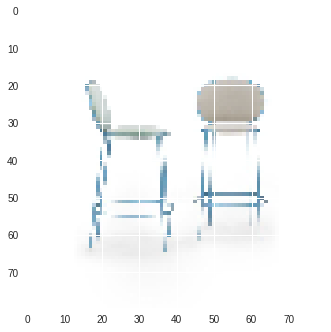

In [5]:
#EDA of the data. Visualizing a random image from each category. No modification were done on any input images as they are sound.
# chair image
plt.imshow(np.array(train_data[1][0]))

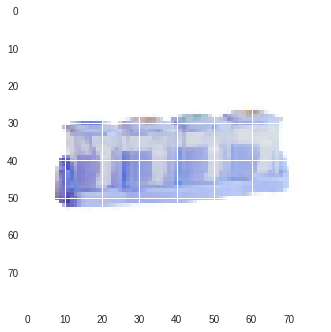

In [6]:
#kitchen image
plt.imshow(np.array(train_data[256][0]))

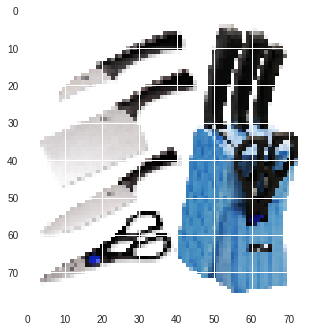

In [7]:
#knife image
plt.imshow(np.array(train_data[111][0]))

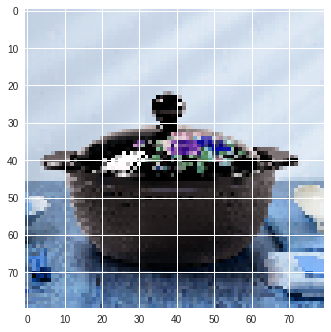

In [8]:
#saucepan image
plt.imshow(np.array(train_data[11][0]))

In [9]:
#In order to implement ALEXNET, we are resizing each image to (227,227,3)
for i in range(len(train_data)):
    train_data[i][0] = cv2.resize(train_data[i][0],(IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET))

for i in range(len(test_data)):
    test_data[i][0] = cv2.resize(test_data[i][0],(IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET))

# splitting data into 80% training data and 20% test.
# training data is split into 4800 training and 400 cross validation images.  

train = train_data[:4800]
cv = train_data[4800:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
cv_y = np.array([i[1] for i in cv])
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
test_y = np.array([i[1] for i in test_data])

#print dimensions of training, test, CV data

print(X.shape)

print(Y.shape)

print(cv_x.shape)

print(test_x.shape)

(4800, 227, 227, 3)
(4800, 4)
(400, 227, 227, 3)
(1267, 227, 227, 3)


In [10]:
steps = len(train)
print(steps)

remaining = steps % step_size

#Resetting graph
tf.reset_default_graph()

#Defining Placeholders 
x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3])
y_true = tf.placeholder(tf.float32,shape=[None,output_classes])

4800


In [11]:
##CONVOLUTION LAYER 1
#Weights for layer 1
weight_1 = tf.Variable(tf.truncated_normal([11,11,3,96], stddev=0.01))
#Bias for layer 1
bias_1 = tf.Variable(tf.constant(0.0, shape=[[11,11,3,96][3]]))
#Applying convolution
convolution_1 = tf.nn.conv2d(x, weight_1,strides=[1, 4, 4, 1], padding='VALID')
#Adding bias
convolution_1 = convolution_1 + bias_1
#Applying RELU
convolution_1 = tf.nn.relu(convolution_1)
								
print(convolution_1)
##POOLING LAYER1
pool_1 = tf.nn.max_pool(convolution_1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(pool_1)


##CONVOLUTION LAYER 2
#Weights for layer 2
weight_2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
#Bias for layer 2
bias_2 = tf.Variable(tf.constant(1.0, shape=[[5,5,96,256][3]]))
#Applying convolution
convolution_2 = tf.nn.conv2d(pool_1, weight_2,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
convolution_2 = convolution_2 + bias_2
#Applying RELU
convolution_2 = tf.nn.relu(convolution_2)

print(convolution_2)

##POOLING LAYER2
pool_2 = tf.nn.max_pool(convolution_2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(pool_2)

##CONVOLUTION LAYER 3
#Weights for layer 3
weight_3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
#Bias for layer 3
bias_3 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 256, 384][3]]))
#Applying convolution
convolution_3 = tf.nn.conv2d(pool_2, weight_3,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
convolution_3 = convolution_3 + bias_3
#Applying RELU
convolution_3 = tf.nn.relu(convolution_3)

print(convolution_3)

##CONVOLUTION LAYER 4
#Weights for layer 4
weight_4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
#Bias for layer 4
bias_4 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 384][3]]))
#Applying convolution
convolution_4 = tf.nn.conv2d(convolution_3, weight_4,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
convolution_4 = convolution_4 + bias_4
#Applying RELU
convolution_4 = tf.nn.relu(convolution_4)

print(convolution_4)

##CONVOLUTION LAYER 5
#Weights for layer 5
weight_5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
#Bias for layer 5
bias_5 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 256][3]]))
#Applying convolution
convolution_5 = tf.nn.conv2d(convolution_4, weight_5,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
convolution_5 = convolution_5 + bias_5
#Applying RELU
convolution_5 = tf.nn.relu(convolution_5)

print(convolution_5)

##POOLING LAYER3
pool_3 = tf.nn.max_pool(convolution_5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(pool_3)

#Flattening
flattened = tf.reshape(pool_3,[-1,6*6*256])
print(flattened)

##Fully Connected Layer 1
#Getting input nodes in FC layer 1
input_size = int( flattened.get_shape()[1] )
#Weights for FC Layer 1
weight1_fc = tf.Variable(tf.truncated_normal([input_size, nodes_fc1], stddev=0.01))
#Bias for FC Layer 1
bias1_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc1] ) )
#Summing Matrix calculations and bias
sum_fc1 = tf.matmul(flattened, weight1_fc) + bias1_fc
#Applying RELU
sum_fc1 = tf.nn.relu(sum_fc1)

#Dropout Layer 1
hold_prob1 = tf.placeholder(tf.float32)
sum_fc1 = tf.nn.dropout(sum_fc1,keep_prob=hold_prob1)

print(sum_fc1)

##Fully Connected Layer 2
#Weights for FC Layer 2
weight2_fc = tf.Variable(tf.truncated_normal([nodes_fc1, nodes_fc2], stddev=0.01))
#Bias for FC Layer 2
bias2_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc2] ) )
#Summing Matrix calculations and bias
sum_fc2 = tf.matmul(sum_fc1, weight2_fc) + bias2_fc
#Applying RELU
sum_fc2 = tf.nn.relu(sum_fc2)
print(sum_fc2)

#Dropout Layer 2
hold_prob2 = tf.placeholder(tf.float32)
sum_fc2 = tf.nn.dropout(sum_fc2,keep_prob=hold_prob1)

##Fully Connected Layer 3
#Weights for FC Layer 3
weight3_fc = tf.Variable(tf.truncated_normal([nodes_fc2,output_classes], stddev=0.01))
#Bias for FC Layer 3b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
bias3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
#Summing Matrix calculations and bias
y_pred = tf.matmul(sum_fc2, weight3_fc) + bias3_fc
#Applying RELU
print(y_pred)


Tensor("Relu:0", shape=(?, 55, 55, 96), dtype=float32)
Tensor("MaxPool:0", shape=(?, 27, 27, 96), dtype=float32)
Tensor("Relu_1:0", shape=(?, 27, 27, 256), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 13, 13, 256), dtype=float32)
Tensor("Relu_2:0", shape=(?, 13, 13, 384), dtype=float32)
Tensor("Relu_3:0", shape=(?, 13, 13, 384), dtype=float32)
Tensor("Relu_4:0", shape=(?, 13, 13, 256), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 6, 6, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 9216), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 4096), dtype=float32)
Tensor("Relu_6:0", shape=(?, 4096), dtype=float32)
Tensor("add_7:0", shape=(?, 4), dtype=float32)


In [0]:
#computing softmax cross_entropy 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

In [0]:
#Defining objective
train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cross_entropy)


#Defining Accuracy
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))

#Initializing weights
init = tf.global_variables_initializer()

#Starting Empty lists to keep results
acc_list = []
auc_list = []
loss_list = []
saver = tf.train.Saver()

#GPU settings
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'

In [14]:
with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(epochs):
        for j in range(0,steps-remaining,step_size):
            #using 0.5 probability on DROPOUT LAYERS
            _,c = sess.run([train,cross_entropy],
			feed_dict={x:X[j:j+step_size] , y_true:Y[j:j+step_size],hold_prob1:0.5,hold_prob2:0.5})
        
        
		#calculating stats. 
        cv_auc = []
        cv_acc = []
        cv_loss = []
        for v in range(0,len(cv_x)-int(len(cv_x) % validating_size),validating_size):
            accuracy_on_cv,loss_on_cv,predictions = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],
			feed_dict={x:cv_x[v:v+validating_size] ,y_true:cv_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
			
            auc_on_cv = roc_auc_score(cv_y[v:v+validating_size],predictions)
            cv_acc.append(accuracy_on_cv)
            cv_auc.append(auc_on_cv)
            cv_loss.append(loss_on_cv)
        acc_cv_ = round(np.mean(cv_acc),5)
        auc_cv_ = round(np.mean(cv_auc),5)
        loss_cv_ = round(np.mean(cv_loss),5)
        acc_list.append(acc_cv_)
        auc_list.append(auc_cv_)
        loss_list.append(loss_cv_)
        print("Epoch:",i,"Accuracy % :",acc_cv_*100,"Loss:",loss_cv_ ,"AUC:",auc_cv_)
    
    test_auc_list = []
    test_acc_list = []
    test_loss_list = []
    for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
        acc_on_test,loss_on_test,predictions = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],
		feed_dict={x:test_x[v:v+validating_size] ,y_true:test_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
        
        auc_on_test = roc_auc_score(test_y[v:v+validating_size],predictions)
        test_acc_list.append(acc_on_test)
        test_auc_list.append(auc_on_test)
        test_loss_list.append(loss_on_test)
    saver.save(sess, os.path.join(os.getcwd(),"CNN_MC.ckpt"))
    test_acc_ = round(np.mean(test_acc_list),5)
    test_auc_ = round(np.mean(test_auc_list),5)
    test_loss_ = round(np.mean(test_loss_list),5)
    print("Test Results are below:")
    print("Accuracy:",test_acc_,"Loss:",test_loss_,"AUC:",test_auc_)


Epoch: 0 Accuracy % : 71.49999737739563 Loss: 0.75384 AUC: 0.91005
Epoch: 1 Accuracy % : 75.0 Loss: 0.63076 AUC: 0.93855
Epoch: 2 Accuracy % : 82.4999988079071 Loss: 0.47794 AUC: 0.96135
Epoch: 3 Accuracy % : 82.24999904632568 Loss: 0.48879 AUC: 0.96698
Epoch: 4 Accuracy % : 83.49999785423279 Loss: 0.45956 AUC: 0.97438
Epoch: 5 Accuracy % : 82.74999856948853 Loss: 0.48612 AUC: 0.97739
Epoch: 6 Accuracy % : 86.2500011920929 Loss: 0.41224 AUC: 0.97953
Epoch: 7 Accuracy % : 86.2500011920929 Loss: 0.39745 AUC: 0.98062
Epoch: 8 Accuracy % : 89.49999809265137 Loss: 0.32733 AUC: 0.98325
Epoch: 9 Accuracy % : 82.24999904632568 Loss: 0.50706 AUC: 0.97812
Epoch: 10 Accuracy % : 85.00000238418579 Loss: 0.47349 AUC: 0.97964
Epoch: 11 Accuracy % : 84.50000286102295 Loss: 0.4876 AUC: 0.97868
Epoch: 12 Accuracy % : 84.50000286102295 Loss: 0.51077 AUC: 0.97746
Epoch: 13 Accuracy % : 88.24999928474426 Loss: 0.41518 AUC: 0.98375
Epoch: 14 Accuracy % : 82.99999833106995 Loss: 0.61463 AUC: 0.9793
Epoch: 1

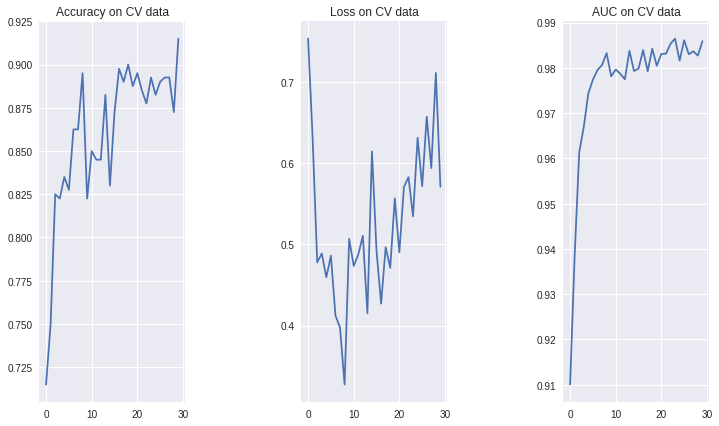

In [15]:
f,ax=plt.subplots(1,3,figsize=(12,3))
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data',ax=ax[0])
pd.Series(loss_list).plot(kind='line',figsize=(12,7),title='Loss on CV data',ax=ax[1])
pd.Series(auc_list).plot(kind='line',figsize=(12,7),title='AUC on CV data',ax=ax[2])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('Accuracy on CV data')
ax[1].set_title('Loss on CV data')
ax[2].set_title('AUC on CV data')
plt.show()


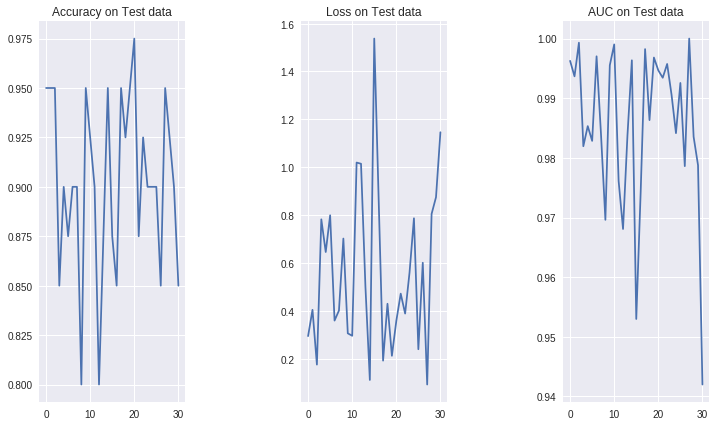

In [16]:
f,ax=plt.subplots(1,3,figsize=(12,3))
pd.Series(test_acc_list).plot(kind='line',title='Accuracy on Test data',ax=ax[0])
pd.Series(test_loss_list).plot(kind='line',figsize=(12,7),title='Loss on Test data',ax=ax[1])
pd.Series(test_auc_list).plot(kind='line',figsize=(12,7),title='AUC on Test data',ax=ax[2])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('Accuracy on Test data')
ax[1].set_title('Loss on Test data')
ax[2].set_title('AUC on Test data')
plt.show()

In [17]:
#Restoring a pretrained
with tf.Session() as session:
    saver.restore(session, "CNN_MC.ckpt")
    print("Model restored.") 
    print('Initialized')
    k = session.run([tf.nn.softmax(y_pred)], feed_dict={x:test_x[0:64] , hold_prob1:1,hold_prob2:1})

print(np.array(k).shape)

#Reshaping k
k = np.array(k).reshape(64,output_classes)

print(k[0])

pred_labels = []

for i in range(64):
    r = np.round(k[i],3).argmax()
    if r ==0 : pred_labels.append("chair")
    elif r ==1: pred_labels.append("kitchen")
    elif r ==2: pred_labels.append("knife")
    elif r ==3: pred_labels.append("saucepan")

INFO:tensorflow:Restoring parameters from CNN_MC.ckpt
Model restored.
Initialized
(1, 64, 4)
[2.3601912e-10 9.9999845e-01 5.5300882e-07 9.4367653e-07]


(64, 227, 227, 3)


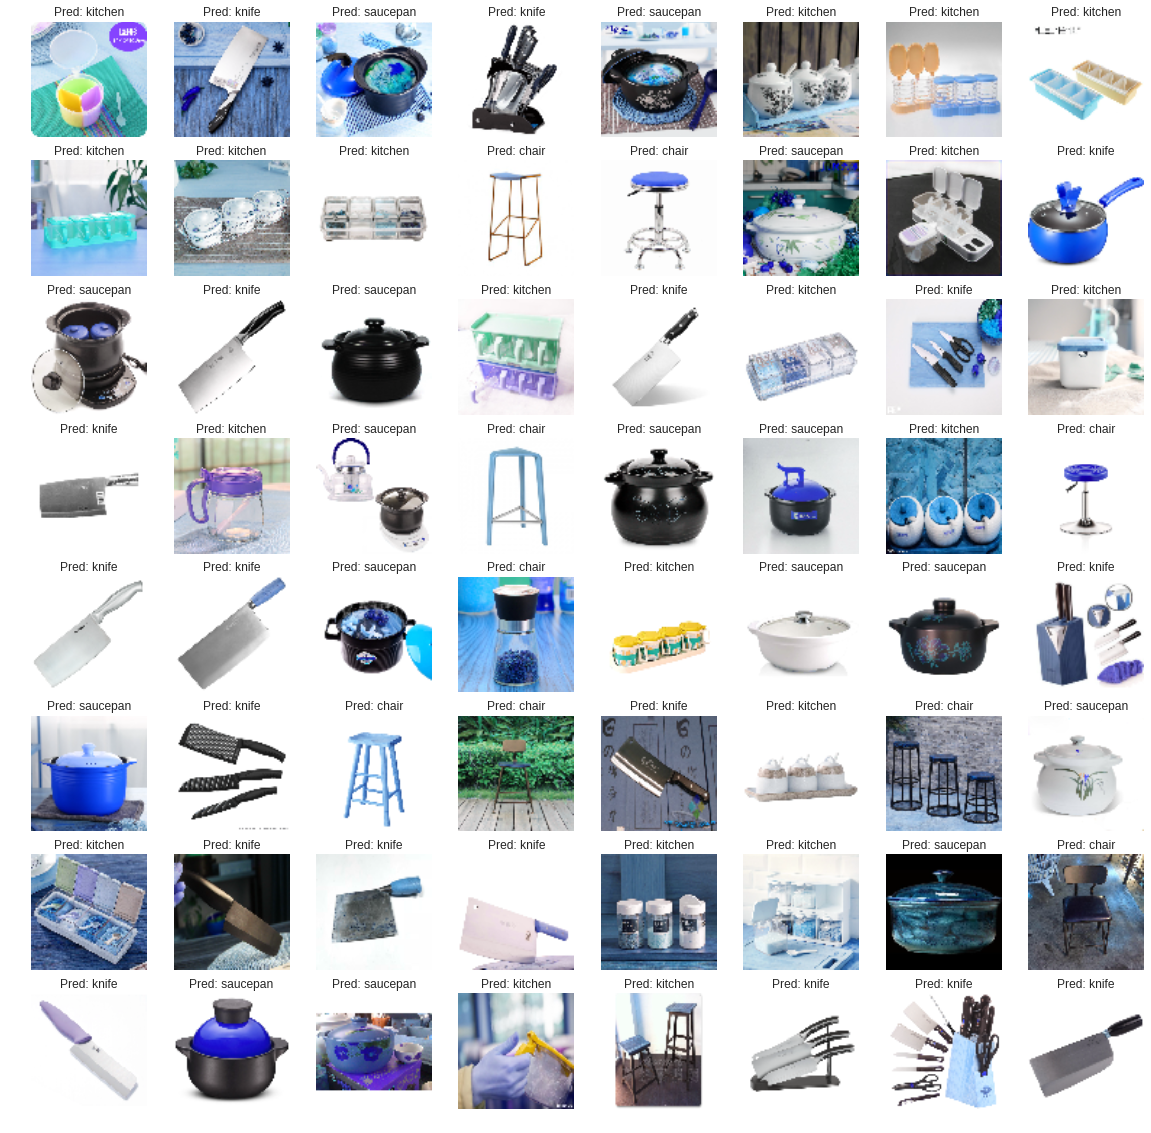

In [18]:
#Multiple images parameters
w=80
h=80
columns = 8
rows = 8

#First 64 images
images = test_x[:64]

print(images.shape)

fig = plt.figure(figsize=(20, 20))
for m in range(1, columns*rows +1):
    img = images[m-1].reshape([IMG_SIZE_ALEXNET, IMG_SIZE_ALEXNET, 3])
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Pred: " + pred_labels[m-1])
    plt.axis('off')
plt.show()